In [150]:
import os
from pickletools import decimalnl_short
from langgraph.graph import StateGraph, END, START
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Cargar las variables del archivo .env
load_dotenv()

# Leer la clave API desde el archivo .env
api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)


In [151]:
# Schema for structured output


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, justification="Why this query is relevant to the user's request.")
    responder: str = Field(None, description="Response from the LLM.")
    search_results: list[str] = Field(None, description="List of search results.")
    search_results_summary: str = Field(None, description="Summary of search results.")

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("La obediencia a los pastores es totalitaria y unilateral en todo orden de cosas en la iglesia cristiana?")
print(f"SEARCH QUERY: {output.search_query}\n")
print(f"JUSTIFICATION: {output.justification}\n")
print(f"RESPONDER: {output.responder}\n")
print(f"SEARCH RESULTS: {output.search_results}\n")
print(f"SEARCH RESULTS SUMMARY: {output.search_results_summary}")




SEARCH QUERY: Totalitarian and unilateral obedience to pastors in Christian church

JUSTIFICATION: The question seeks to explore the nature of obedience within the Christian church and how it relates to authority dynamics between congregations and their leaders.

RESPONDER: En la iglesia cristiana, la obediencia a los pastores puede variar según la denominación y la cultura de la congregación. Sin embargo, algunos críticos argumentan que en ciertas comunidades la obediencia se percibe como totalitaria y unilateral, donde los pastores ejercen un control sobre los miembros de la iglesia que limita la autonomía y la capacidad de cuestionar decisiones. Este enfoque puede provocar un ambiente donde se espera que los fieles sigan las enseñanzas y decisiones del pastor sin resistencia. Por otra parte, también hay congregaciones donde se reconoce la importancia de la voz de la comunidad y se fomenta un modelo de liderazgo más colaborativo.

SEARCH RESULTS: ['Do church leaders want more control

# Prompt Chaining

![prompt_chaining](img/prompt_chaining.png "Prompt_chaining")

Each LLM call processes  the putput  of the previous one:
- E.g., when decomposing a task into multiple LLM calls has benefit

## Example

_Take a topic, LLM make a joke, LLM improve the joke, LLM transform a chilean joke._


In [152]:

# Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [153]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate a initial joke."""

    msg = llm.invoke(f"Write a short joke about {state['topic']}.")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke."""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def chilean_joke(state: State):
    """Third LLM call for final chilean joke."""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function  to check  if the joke  has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline."""

    # Simple check - does  the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

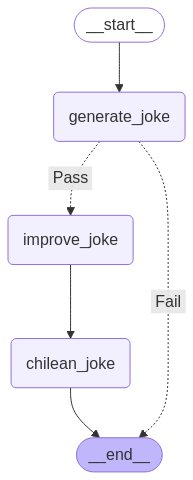

In [154]:
# Build workflow
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("chilean_joke", chilean_joke)

# Add Edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "chilean_joke")
workflow.add_edge("chilean_joke", END)

# Compile
chain =  workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [155]:
state = chain.invoke({"topic": "ñuñoinos progres"})
print("Inital joke: ")
print(state["joke"])
print("\n--- --- ---")
if "improved_joke" in state:
    print("Improved joke: ")
    print(state["improved_joke"])
    print("\n--- --- ---")

    print("Final joke: ")
    print(state["final_joke"])
else :
    print("Joke failed quality gate - no punchline detetected!")

Inital joke: 
Why did the ñuñoinos progres always carry a map?

Because they were always looking for their next "progress" point!

--- --- ---
Improved joke: 
Why did the ñuñoinos progres always carry a map? 

Because they couldn't resist making "proGRASS" on their journey to the next "progress" point!

--- --- ---
Final joke: 
Why did the ñuñoinos progres always carry a map? 

Because they couldn't resist making "proGRASS" on their journey to the next "progress" point! But little did they know, they were actually following a treasure map that led to a hidden stash of organic kale—even their GPS couldn't handle that level of "healthy living!"


# Parallelization
![Parallelization](img/parallelization.png "Parallelization")

- Sub-tasks can be parallelized.
  - E.g., when you want multi-perspectives for one task (multi-query for RAG).
  - E.g., when independent tasks can be performed w/ different prompts.


- Las subtareas pueden paralelizarse.
  - Por ejemplo, cuando se desean múltiples perspectivas para una tarea (consulta múltiple para RAG).
  - Por ejemplo, cuando las tareas independientes pueden realizarse con diferentes indicaciones (prompts).

## Example:
_Take a topic, create a Joke, Story and Poem._


In [156]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [157]:
# Nodes

def generate_joke(state: State):
    """First LLM call to generate a initial joke."""

    msg = llm.invoke(f"Write a short joke about {state['topic']}.")
    return {"joke": msg.content}

def generate_story(state: State):
    """Second LLM call to generate a story."""

    msg = llm.invoke(f"Write a short story about {state['topic']}.")
    return {"story": msg.content}

def generate_poem(state: State):
    """Third LLM call to generate a poem."""

    msg = llm.invoke(f"Write a short poem about {state['topic']}.")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke, story and peom into a single output."""

    combined = f"""This is a combintation of a joke, a story and a poem about {state['topic']}.

JOKE: {state['joke']}

STORY: {state['story']}

POEM: {state['poem']}"""

    return {"combined_output": combined}

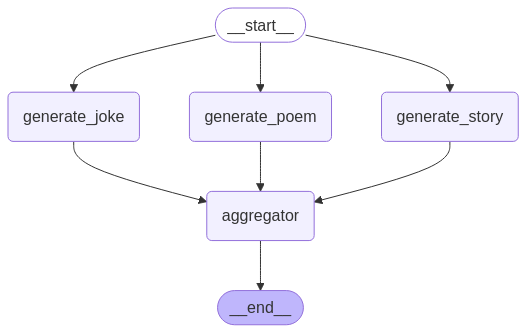

In [158]:
# Build Workflow
parallel_builder = StateGraph(State)

# Add Nodes
parallel_builder.add_node("generate_joke", generate_joke)
parallel_builder.add_node("generate_story", generate_story)
parallel_builder.add_node("generate_poem", generate_poem)
parallel_builder.add_node("aggregator", aggregator)

# Add Edges and connect nodes
parallel_builder.add_edge(START, "generate_joke")
parallel_builder.add_edge(START, "generate_story")
parallel_builder.add_edge(START, "generate_poem")
parallel_builder.add_edge("generate_joke", "aggregator")
parallel_builder.add_edge("generate_story", "aggregator")
parallel_builder.add_edge("generate_poem", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [159]:
state = parallel_workflow.invoke({"topic": "Amor a las hijas"})
print(state["combined_output"])

This is a combintation of a joke, a story and a poem about Amor a las hijas.

JOKE: ¿Por qué el amor de un padre por sus hijas no tiene límites? 

¡Porque siempre llevan en el corazón la "hija" de su vida!

STORY: **Amor a las Hijas**

En un pequeño pueblo cubierto por la bruma de la mañana, vivía Doña Elena, una madre de tres hijas: Valeria, Lucía y Camila. Su hogar se llenaba de risas y sueños, pero también de las dificultades que enfrentaban por ser una familia unida en un mundo que a menudo parecía querer separarlas.

Doña Elena era la dueña de un taller de costura, donde con agujas y hilos tejía no solo telas, sino también los recuerdos de su familia. Cada vestido, cada prenda llevaba consigo una historia de amor y sacrificio. Ella creía firmemente que la esencia del amor se encontraba en los pequeños detalles, en las charlas nocturnas, en compartir un café, y en las caricias delicadas que ofrecía a sus hijas cuando el mundo exterior se tornaba difícil.

Una tarde, mientras Doña E

# Routing

![Routing](img/routing.png "routing")

Routing classifies an input and directs it to a specialized follow-up task.
- E.g., when routing a question to different retrieval systems.

El enrutamiento clasifica una entrada y la dirige a una tarea de seguimiento especializada.
- Por ejemplo, cuando se enruta una pregunta a diferentes sistemas de recuperación.

Example:
- Route an input between joke, story, and poem.







In [160]:
# Schema for structured output to use  as routing logic
class Route(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(None, description="The next step in the routing process")

# Augment the LLM  with schema  for structured output
router = llm.with_structured_output(Route)


In [161]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [162]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def generate_story(state: State):
    """Write the story"""

    print("Write the story:")
    result = llm.invoke(state['input'])
    return {"output": result.content}

def generate_poem(state: State):
    """Write the poem"""

    print("Write the poem:")
    result = llm.invoke(state['input'])
    return {"output": result.content}

def generate_joke(state: State):
    """Write the joke"""

    print("Write the joke:")
    result = llm.invoke(state['input'])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # run the augmented LLM with structured output to serve  as routing  logic
    decision = router.invoke(
        [
            SystemMessage(content="Route the input story, joke, or poem based  on the user's request"),
            HumanMessage(content=state['input']),
        ]
    )
    return {"decision": decision.step}

# Conditional edge function  to route for the appropiate node
def route_decision(state: State):
    """Gate function to route the input to the appropriate node"""
    # Return the node name you want to visit next
    if state["decision"] == "joke":
        return "generate_joke"
    elif state["decision"] == "story":
        return "generate_story"
    elif state["decision"] == "poem":
        return "generate_poem"


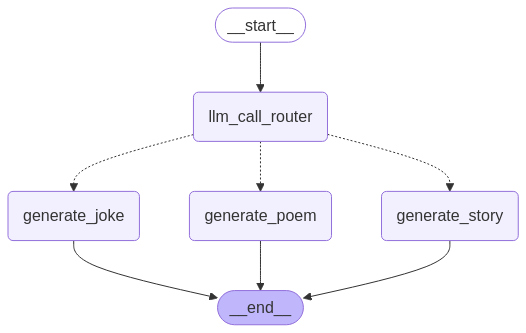

In [163]:
# Builder workflow
router_builder = StateGraph(State)

# Node
router_builder.add_node("generate_story", generate_story)
router_builder.add_node("generate_poem", generate_poem)
router_builder.add_node("generate_joke", generate_joke)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        # Name returned by route_decision: Name of the next node to visit
        "generate_story": "generate_story",
        "generate_poem": "generate_poem",
        "generate_joke": "generate_joke",
    }
)

router_builder.add_edge("generate_story", END)
router_builder.add_edge("generate_poem", END)
router_builder.add_edge("generate_joke", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [164]:
state = router_workflow.invoke({"input": "Write me a joke about a cat."})
print(state["output"])

Write the joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


# Orchestrator worker
![orchestrator](img/orchestrator_worker.png)

Orchestrator breaks down a task and delegates each sub-task to workers.
- E.g., planning a report where LLM can determine the number of sections.

Example:
- Take a topic, plan a report of section, have each worker write a section.

- When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

Example where orchestrator-workers is useful:

Coding products that make complex changes to multiple files each time.
Search tasks that involve gathering and analyzing information from multiple sources for possible relevant information.

---

El orquestador descompone una tarea y delega cada subtarea a los trabajadores.
- Por ejemplo, planificar un informe donde el LLM pueda determinar el número de secciones.

Ejemplo:
- Tomar un tema, planificar un informe por secciones y hacer que cada trabajador escriba una sección.

- Cuándo usar este flujo de trabajo:

Este flujo de trabajo es ideal para tareas complejas donde no se pueden predecir las subtareas necesarias (en codificación, por ejemplo, la cantidad de archivos que deben modificarse y la naturaleza del cambio en cada archivo probablemente dependan de la tarea). Si bien es topográficamente similar, la diferencia clave con la paralelización es su flexibilidad: las subtareas no están predefinidas, sino que el orquestador las determina en función de la entrada específica.

Ejemplos de utilidad de los trabajadores del orquestador:

Productos de codificación que realizan cambios complejos en varios archivos cada vez.
Tareas de búsqueda que implican recopilar y analizar información de múltiples fuentes para encontrar posible información relevante.




In [165]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [166]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    # Imprimir todas las secciones generadas
    print("\nSecciones generadas para el informe:")
    for idx, section in enumerate(report_sections.sections):
        print(f"Sección {idx + 1}:")
        print(f" - Título: {section.name}")
        print(f" - Descripción: {section.description}")

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]




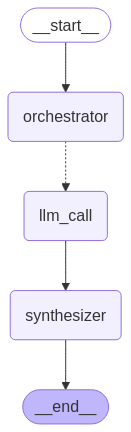

In [167]:
from langgraph.constants import Send

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [168]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Metodología para disponibilizar en producción herramientas de IA con Langgraph"})


Secciones generadas para el informe:
Sección 1:
 - Título: Introducción
 - Descripción: Presentación del tema de la metodología para implementar herramientas de IA utilizando Langgraph, incluyendo el objetivo del informe y la relevancia del tema.
Sección 2:
 - Título: Marco Teórico
 - Descripción: Definición de conceptos clave como la inteligencia artificial, Langgraph, y tecnologías relacionadas, además de una revisión de la literatura sobre metodologías de implementación.
Sección 3:
 - Título: Metodología Propuesta
 - Descripción: Descripción detallada de los pasos y procesos necesarios para implementar herramientas de IA en producción usando Langgraph, incluyendo la planificación, desarrollo, prueba y despliegue.
Sección 4:
 - Título: Casos de Uso
 - Descripción: Ejemplos prácticos de cómo se puede aplicar la metodología en diferentes escenarios y sectores, destacando resultados y beneficios esperados.
Sección 5:
 - Título: Desafíos y Consideraciones
 - Descripción: Análisis de los

> descometar para ver el reporte en markdown


In [169]:
from IPython.display import Markdown
# Markdown(state["final_report"]) # Descomentar para ver el markdown generado.


In [170]:
import os

# Crear carpeta 'docs' si no existe
os.makedirs("docs", exist_ok=True)

# Guardar el contenido en un archivo .md
with open("docs/reporte.md", "w") as file:
    file.write(state["final_report"])

# Evaluator - Optimizer

![evaluator](img/evaluator-optimizer.png)

### **Cuándo usar este flujo de trabajo:**
Este flujo de trabajo es particularmente efectivo cuando tenemos criterios de evaluación claros y cuando el refinamiento iterativo proporciona un valor medible. Las dos señales de un buen ajuste son, primero, que las respuestas de los LLM pueden mejorarse de manera demostrable cuando un humano articula sus comentarios; y segundo, que el LLM puede proporcionar dichos comentarios. Esto es análogo al proceso de escritura iterativo por el que pasaría un escritor humano al producir un documento pulido.

### **Ejemplos donde el evaluador-optimizador es útil:**

- Traducción literaria donde hay matices que el traductor LLM podría no captar inicialmente, pero donde un evaluador LLM puede proporcionar críticas útiles.
- Tareas de búsqueda complejas que requieren múltiples rondas de búsqueda y análisis para recopilar información completa, donde el evaluador decide si se justifican más búsquedas.

---

## **Agentes**
Los agentes están emergiendo en producción a medida que los LLM maduran en capacidades clave: comprender entradas complejas, participar en razonamiento y planificación, usar herramientas de manera confiable y recuperarse de errores.

Los agentes comienzan su trabajo con un comando o con una discusión interactiva con el usuario humano. Una vez que la tarea está clara, los agentes planifican y operan de manera independiente, volviendo potencialmente al humano para obtener más información o juicio. Durante la ejecución, es crucial que los agentes obtengan la "verdad fundamental" del entorno en cada paso (como resultados de herramientas o ejecución de código) para evaluar su progreso.

Los agentes pueden pausar para recibir comentarios humanos en puntos de control o cuando encuentren bloqueos. La tarea a menudo termina al completarse, pero también es común incluir condiciones de detención (como un número máximo de iteraciones) para mantener el control.

Los agentes pueden manejar tareas sofisticadas, pero su implementación suele ser sencilla. Normalmente, son solo LLM utilizando herramientas basadas en comentarios ambientales en un ciclo. Por lo tanto, es crucial diseñar los conjuntos de herramientas y su documentación de manera clara y reflexiva. Ampliamos las mejores prácticas para el desarrollo de herramientas en el Apéndice 2 ("Ingeniería de prompts para tus herramientas").

![evaluator](img/evaluator-optimizer-stop.png)


In [171]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    """Feedback from the LLM"""
    grade: Literal["good", "bad"] = Field(
        description="Grade of the feedback"
    )
    feedback: str = Field(
        description="Feedback from the LLM. if the grade is good, the feedback is empty."
    )

evaluator = llm.with_structured_output(Feedback)

In [172]:
# Graph
class State(TypedDict):
    texto: str
    topic: str
    feedback: str
    good_or_bad: str

In [173]:
# Nodes
def llm_call_generator(state: State):
    """
    Generates a text about a given topic using an LLM (Language Learning Model),
    optionally considering additional feedback provided in the state.
    """
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a text about: {state['topic']}. but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a text about: {state['topic']}.")
    return {"texto": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluate the texto, if correct or not"""

    grade = evaluator.invoke(f"Grade the texto: {state['texto']}")
    return {"good_or_bad": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to text generator or end based upon feedback from the evaluator
def route_text(state:State):
    """Route back to text generator or end based upon feedback from the evaluator"""

    if state["good_or_bad"] == "good":
        return "Accepted"
    elif state["good_or_bad"] == "bad":
        return "Rejected + Feedback"


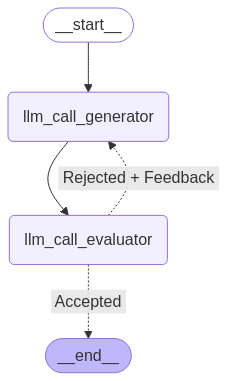

In [174]:
# Workflow
optimizer_builder = StateGraph(State)

# Add Nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)


# Add Edges
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_text,
    {  # Name returned by route_text : Name de the next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator"
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))



In [175]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Generación propuesta de valor de Agentes Conversacionales usando langgraph."})
print(state['texto'])

**Generación de Propuesta de Valor de Agentes Conversacionales Usando LangGraph**

En la actualidad, los agentes conversacionales se han convertido en herramientas esenciales para la interacción entre empresas y clientes. Con el avance de la inteligencia artificial y el procesamiento del lenguaje natural, estos sistemas están mejorando su capacidad para comprender y responder a las consultas de los usuarios de manera más efectiva. LangGraph es una innovadora plataforma que permite a los desarrolladores y empresas crear agentes conversacionales personalizados, optimizando la generación de propuestas de valor que resuenen con las necesidades específicas de sus usuarios.

### ¿Qué es LangGraph?

LangGraph es una herramienta de desarrollo que integra varias tecnologías de procesamiento de lenguaje natural (PLN) y aprendizaje automático para ayudar a las empresas a diseñar y desplegar agentes conversacionales de alta calidad. La plataforma ofrece una interfaz intuitiva para crear flujos de 

In [176]:
from IPython.display import Markdown
Markdown(state["texto"]) # Descomentar para ver el markdown generado.

**Generación de Propuesta de Valor de Agentes Conversacionales Usando LangGraph**

En la actualidad, los agentes conversacionales se han convertido en herramientas esenciales para la interacción entre empresas y clientes. Con el avance de la inteligencia artificial y el procesamiento del lenguaje natural, estos sistemas están mejorando su capacidad para comprender y responder a las consultas de los usuarios de manera más efectiva. LangGraph es una innovadora plataforma que permite a los desarrolladores y empresas crear agentes conversacionales personalizados, optimizando la generación de propuestas de valor que resuenen con las necesidades específicas de sus usuarios.

### ¿Qué es LangGraph?

LangGraph es una herramienta de desarrollo que integra varias tecnologías de procesamiento de lenguaje natural (PLN) y aprendizaje automático para ayudar a las empresas a diseñar y desplegar agentes conversacionales de alta calidad. La plataforma ofrece una interfaz intuitiva para crear flujos de conversación, así como herramientas de análisis que permiten entender mejor cómo interactúan los usuarios con el sistema.

### Generación de Propuesta de Valor

La propuesta de valor de un agente conversacional se refiere a la manera en que este puede resolver problemas específicos de los usuarios, mejorar la eficiencia operativa y, en última instancia, incrementar la satisfacción del cliente. LangGraph facilita este proceso a través de varias características clave:

1. **Personalización Avanzada**: Con LangGraph, las empresas pueden ajustar sus agentes conversacionales para reflejar el tono y estilo de comunicación deseado, así como adaptar las respuestas y flujos de conversación según el perfil del usuario. Esto permite ofrecer una experiencia más relevante y atractiva.

2. **Análisis de Interacciones**: La plataforma proporciona herramientas para analizar las interacciones pasadas, identificando patrones y áreas de mejora. Esta retroalimentación continua es fundamental para ajustar la propuesta de valor, asegurando que el agente evolucione con las expectativas y necesidades del usuario.

3. **Integración con API**: LangGraph facilita la integración con otras plataformas y servicios, permitiendo a los agentes acceder a datos en tiempo real y ofrecer respuestas precisas basadas en información actual. Esto es crucial para empresas que operan en sectores donde la inmediatez y precisión de la información son esenciales.

4. **Mejora Continua**: A través de metodologías de aprendizaje automático, los agentes conversacionales pueden aprender de cada interacción, mejorando su capacidad para entender y anticipar las necesidades del usuario con el tiempo. Esto permite una evolución constante de la propuesta de valor, manteniéndola siempre alineada con el mercado.

5. **Escalabilidad**: LangGraph permite la creación de agentes que pueden manejar un número creciente de interacciones a medida que la empresa crece, asegurando que la calidad del servicio no se vea comprometida. Esta capacidad de escalar es fundamental para muchas empresas que buscan expandir su presencia en mercados competitivos.

### Conclusión

La generación de propuestas de valor efectivas a través de agentes conversacionales es un desafío que puede ser superado con las herramientas adecuadas. LangGraph emerge como una solución integral, potenciando la capacidad de las empresas para diseñar agentes conversacionales que no solo respondan preguntas, sino que también creen experiencias significativas y memorables. Al poner el foco en la personalización, el análisis de datos y la mejora continua, LangGraph permite a las empresas ofrecer verdadero valor a sus usuarios y beneficiarse de interacciones más eficientes y efectivas. En un mundo donde la atención del cliente es crucial, esta propuesta de valor es más relevante que nunca.

In [177]:
Markdown(state["feedback"])

In [178]:
state

{'texto': '**Generación de Propuesta de Valor de Agentes Conversacionales Usando LangGraph**\n\nEn la actualidad, los agentes conversacionales se han convertido en herramientas esenciales para la interacción entre empresas y clientes. Con el avance de la inteligencia artificial y el procesamiento del lenguaje natural, estos sistemas están mejorando su capacidad para comprender y responder a las consultas de los usuarios de manera más efectiva. LangGraph es una innovadora plataforma que permite a los desarrolladores y empresas crear agentes conversacionales personalizados, optimizando la generación de propuestas de valor que resuenen con las necesidades específicas de sus usuarios.\n\n### ¿Qué es LangGraph?\n\nLangGraph es una herramienta de desarrollo que integra varias tecnologías de procesamiento de lenguaje natural (PLN) y aprendizaje automático para ayudar a las empresas a diseñar y desplegar agentes conversacionales de alta calidad. La plataforma ofrece una interfaz intuitiva para